In [2]:
%pip install -r ../requirements.txt

   ---------------------------------------- 0.0/815.2 kB ? eta -:--:--
   --------------------------------------- 815.2/815.2 kB 17.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/927.3 kB ? eta -:--:--
   --------------------------------------- 927.3/927.3 kB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/819.3 kB ? eta -:--:--
   --------------------------------------- 819.3/819.3 kB 18.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
base_dir: bool = False

In [3]:
import os, sys

if not base_dir:
    os.chdir('../')
    base_dir = True

import numpy as np, pandas as pd, matplotlib.pyplot as plt, sklearn, torch

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn

from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

from utils.data_tools import inbreast, cbis_ddsm, image_processing
from utils.models import models

import tensorflow as tf

In [6]:
inbreast.download()
cbis_ddsm.download()

Path already exists for INBreast!
Path already exists for CBIS-DDSM!


In [70]:
# Testing Data

class cbis_ddsm_data:

    x_train, x_test, y_train, y_test = data = cbis_ddsm.get_images()

class inbreast_data:

    x_train, x_test, y_train, y_test = data = inbreast.get_images()

    x, y = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])

409/409


Pixel Distribution: shape (224, 224), mean 0.218909, std 0.241540, min 0.000000, max 1.000000, unique 229


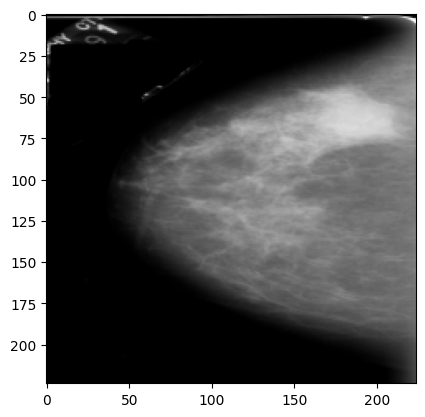

In [77]:
import matplotlib.pyplot as plt

img = cbis_ddsm_data.x_train[0]

print(
    f"Pixel Distribution: shape {img.shape}, mean {np.mean(img):2f}, std {np.std(img):2f}, min {np.min(img):2f}, max {np.max(img):2f}, unique {np.unique(img.flatten()).shape[0]}"
)

plt.imshow(
    img,
    cmap='gray',
)

In [78]:
cbis_ddsm_data.y_train[0]

0

In [172]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.__len__()

    def __getitem__(self, idx):

        image = torch.tensor(np.expand_dims(self.x[idx], axis=0), dtype=torch.float32)
        label = torch.tensor([0, 1] if self.y[idx] else [1, 0], dtype=torch.float32)

        return image, label

def get_loader(x, y, batch_size=32):

    loader = DataLoader(CustomImageDataset(x, y), batch_size=batch_size, shuffle=True)

    return loader

def get_loader_test(x, y, batch_size=32):

    loader = DataLoader(CustomImageDataset(x, y), batch_size=batch_size)

    return loader

In [173]:
l = get_loader(cbis_ddsm_data.x_train, cbis_ddsm_data.y_train)
vl = get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)

In [104]:
cbis_ddsm_data.y_train

array([0, 1, 1, ..., 0, 1, 0])

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class CNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=8, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=8, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=8, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return F.softmax(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        print(f'Train Crossentropy', loss.item())
        return loss
    
    def val_dataloader(self):
        return get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)
    
    def validation_step(self, batch, batch_idx):
        # Forward pass
        inputs, targets = batch
        outputs = self(inputs)
        
        # Compute loss
        loss = F.cross_entropy(outputs, targets)
        
        # Log validation loss
        print(f'Val Crossentropy', loss.item())
        self.log('val_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        # Custom prediction logic
        x, y = batch  # Adjust based on how your DataLoader returns data
        logits = self.forward(x)
        predictions = F.softmax(logits, dim=-1)
        return predictions

    # def train_dataloader(self):
    #     return self.data

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [167]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar

progress_bar = TQDMProgressBar(refresh_rate=10)

model = CNNModel()
trainer = Trainer(max_epochs=10, enable_progress_bar=False)

trainer.fit(model, l)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | conv1 | Conv2d     | 260    | train
1 | conv2 | Conv2d     | 2.1 K  | train
2 | conv3 | Conv2d     | 8.2 K  | train
3 | fc1   | LazyLinear | 0      | train
4 | fc2   | Linear     | 32.9 K | train
5 | fc3   | Linear     | 8.3 K  | train
6 | fc4   | Linear     | 1.0 K  | train
7 | fc5   | Linear     | 34     | train
---------------------------------------------
52.8 K    Trainable params
0         Non-trainable params
52.8 K    Total params
0.211     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
c:\Users\Theon\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\

Val Crossentropy 0.7060362100601196
Val Crossentropy 0.7023176550865173
Train Crossentropy 0.6986098289489746
Train Crossentropy 0.684289813041687
Train Crossentropy 0.7015707492828369
Train Crossentropy 0.6964569091796875
Train Crossentropy 0.7073579430580139
Train Crossentropy 0.7019940614700317
Train Crossentropy 0.6936681866645813
Train Crossentropy 0.689265251159668
Train Crossentropy 0.6908547282218933
Train Crossentropy 0.6753029227256775
Train Crossentropy 0.6620222926139832
Train Crossentropy 0.6096194982528687
Train Crossentropy 0.6797274947166443
Train Crossentropy 0.608947217464447
Train Crossentropy 0.5534362196922302
Train Crossentropy 0.5226048231124878
Train Crossentropy 0.4925267994403839
Train Crossentropy 0.4126718044281006
Train Crossentropy 0.39180001616477966
Train Crossentropy 0.4452798366546631
Train Crossentropy 0.3612626791000366
Train Crossentropy 0.4070727229118347
Train Crossentropy 0.3713705837726593
Train Crossentropy 0.39083433151245117
Train Crossentrop

`Trainer.fit` stopped: `max_epochs=10` reached.


Val Crossentropy 0.3758925199508667
Val Crossentropy 0.31326165795326233


In [ ]:
testl = get_loader_test(inbreast_data.x, inbreast_data.y)

y_pred = trainer.predict(model, testl)

print(f"""
Test Loss: {F.cross_entropy(torch.concat(y_pred), torch.from_numpy(inbreast_data.y).long())}
Accuracy: {(torch.argmax(torch.concat(y_pred), dim=1) == torch.from_numpy(inbreast_data.y).long()).count_nonzero() / torch.concat(y_pred).shape[0]}     
""")

In [179]:
testl = get_loader_test(inbreast_data.x, inbreast_data.y)

y_pred = trainer.predict(model, testl)

print(f"""
Test Loss: {F.cross_entropy(torch.concat(y_pred), torch.from_numpy(inbreast_data.y).long())}
Accuracy: {(torch.argmax(torch.concat(y_pred), dim=1) == torch.from_numpy(inbreast_data.y).long()).count_nonzero() / torch.concat(y_pred).shape[0]}     
""")

C:\Users\Theon\AppData\Local\Temp\ipykernel_12156\3237781080.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test Loss: 0.5076141953468323
Accuracy: 0.9584352374076843     



In [178]:
torch.save(model.state_dict(), 'models/model_weights.pt')

In [177]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6007 (pid 22132), started 0:32:41 ago. (Use '!kill 22132' to kill it.)